In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tqdm import tqdm
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.model_selection import train_test_split


In [17]:
train = pd.read_csv('train.csv')
train.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


In [18]:
print("Null values(train):") 
print(train.isnull().sum())
print("\n")
countries = train['Country_Region'].unique()
print("Number of different countries: ", len(countries))
print("\n")
min_date = train.Date.min()
max_date = train.Date.max()
print("Min date: {0}\nMax date: {1}".format(min_date, max_date))

Null values(train):
Id                    0
Province_State    13376
Country_Region        0
Date                  0
ConfirmedCases        0
Fatalities            0
dtype: int64


Number of different countries:  180


Min date: 2020-01-22
Max date: 2020-04-06


In [19]:
def fillState(state, country):
    if state == "empty":
        return country
    return state

train['Province_State'].fillna("empty", inplace = True)
train['Province_State'] = train.loc[:,['Province_State', 'Country_Region']].apply(lambda x: fillState(x['Province_State'], x['Country_Region']), axis = 1)


# renaming columns
train=train.rename(columns={'ConfirmedCases':'Confirmed'})

num_cols=['Confirmed', 'Fatalities']

# cast to int
for col in num_cols:
    temp=[int(i) for i in train[col]]
    train[col]=temp 
    
train.head()

,Id,Province_State,Country_Region,Date,Confirmed,Fatalities
0,1,Afghanistan,Afghanistan,2020-01-22,0,0
1,2,Afghanistan,Afghanistan,2020-01-23,0,0
2,3,Afghanistan,Afghanistan,2020-01-24,0,0
3,4,Afghanistan,Afghanistan,2020-01-25,0,0
4,5,Afghanistan,Afghanistan,2020-01-26,0,0


In [20]:
train['Date'] = pd.to_datetime(train['Date'], infer_datetime_format = True)
train_countries = train.groupby("Country_Region")
train_countries.get_group('Serbia').set_index("Date").head()

,Id,Province_State,Country_Region,Confirmed,Fatalities
Date,,,,,
2020-01-22,22364,Serbia,Serbia,0,0
2020-01-23,22365,Serbia,Serbia,0,0
2020-01-24,22366,Serbia,Serbia,0,0
2020-01-25,22367,Serbia,Serbia,0,0
2020-01-26,22368,Serbia,Serbia,0,0


In [21]:
Confirmed = pd.pivot_table(train, values = "Confirmed", index = "Date", columns = "Country_Region")
Fatalities = pd.pivot_table(train, values = "Fatalities", index = "Date", columns = "Country_Region")
Confirmed

Country_Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-02,273.0,277.0,986.0,428.0,8.0,9.0,1133.0,663.0,639.500,11129.0,...,897.0,1024.0,3417.3,350.0,205.0,146.0,233.0,161.0,39.0,9.0
2020-04-03,281.0,304.0,1171.0,439.0,8.0,15.0,1265.0,736.0,666.250,11524.0,...,1072.0,1264.0,3868.9,369.0,227.0,153.0,237.0,194.0,39.0,9.0
2020-04-04,299.0,333.0,1251.0,466.0,10.0,15.0,1451.0,770.0,693.750,11781.0,...,1225.0,1505.0,4247.6,400.0,266.0,155.0,240.0,217.0,39.0,9.0


In [22]:
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequences):
            break
            
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
        
    return np.array(X), np.array(y)


In [75]:
#Confirmed = Confirmed.values
#Fatalities = Fatalities.values
n_steps_in, n_steps_out = 2, 1
X_confirmed, y_confirmed = split_sequences(Confirmed, n_steps_in, n_steps_out)
X_fatalities, y_fatalities = split_sequences(Fatalities, n_steps_in, n_steps_out)
print(X_confirmed.shape, y_confirmed.shape)
print(X_fatalities.shape, y_fatalities.shape)


(74, 2, 180) (74, 1, 180)
(74, 2, 180) (74, 1, 180)


### Split the data into train and test sets

In [100]:

X_train_confirmed, X_val_confirmed, y_train_confirmed, y_val_confirmed = train_test_split(X_confirmed, y_confirmed, test_size = 0.1, random_state = 42)
X_train_fatal, X_val_fatal, y_train_fatal, y_val_fatal = train_test_split(X_fatalities, y_fatalities, test_size = 0.2, random_state = 42)

### Model for confirmed cases

In [89]:
n_features = X_confirmed.shape[2]
epochs = 200
batch_size = 32

from keras.layers import RepeatVector, TimeDistributed

model_confirmed = Sequential()
model_confirmed.add(LSTM(50, activation='relu', input_shape =(n_steps_in, n_features)))
#model_confirmed.add(Dropout(0.1))
model_confirmed.add(RepeatVector(n_steps_out))
model_confirmed.add(LSTM(150, activation ='relu', return_sequences = True))
model_confirmed.add(TimeDistributed(Dense(n_features)))

model_confirmed.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 50)                46200     
_________________________________________________________________
repeat_vector_15 (RepeatVect (None, 1, 50)             0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 1, 150)            120600    
_________________________________________________________________
time_distributed_12 (TimeDis (None, 1, 180)            27180     
Total params: 193,980
Trainable params: 193,980
Non-trainable params: 0
_________________________________________________________________


In [104]:
# msle error penalizes underestimates more than overestimates
# msle only cares about relative difference between true and predicted value

model_confirmed.compile(optimizer='adam', loss = 'msle', metrics = ['acc'])
#callbacks = [ReduceLROnPlateau(monitor='val_l|oss', patience = 5, verbose = 1, factor = 0.6),
 #            EarlyStopping(monitor='val_loss', patience = 20),
  #           ModelCheckpoint(filepath = 'best_model_confirmed.h5', monitor ='val_loss', save_best_only = True)]

# fit the model
hist = model_confirmed.fit(X_train_confirmed, y_train_confirmed, epochs = epochs,  
                    validation_data = (X_val_confirmed, y_val_confirmed), verbose = 0)

In [105]:
scores = model_confirmed.evaluate(X_train_confirmed, y_train_confirmed)
print("Model accuracy: %.2f"%(scores[1]*100),"%")

66/66 [==============================] - 0s 190us/step
Model accuracy: 84.85 %


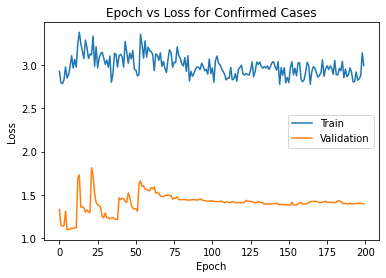

In [106]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Epoch vs Loss for Confirmed Cases')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

### Model for fatal cases

In [101]:
n_features = X_fatalities.shape[2]
epochs = 200
batch_size = 32


model_fatalities = Sequential()
model_fatalities.add(LSTM(50, activation='relu', input_shape =(n_steps_in, n_features)))
model_confirmed.add(Dropout(0.1))
model_fatalities.add(RepeatVector(n_steps_out))
model_fatalities.add(LSTM(150, activation ='relu', return_sequences = True))
model_fatalities.add(TimeDistributed(Dense(n_features)))

model_fatalities.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_34 (LSTM)               (None, 50)                46200     
_________________________________________________________________
repeat_vector_18 (RepeatVect (None, 1, 50)             0         
_________________________________________________________________
lstm_35 (LSTM)               (None, 1, 150)            120600    
_________________________________________________________________
time_distributed_15 (TimeDis (None, 1, 180)            27180     
Total params: 193,980
Trainable params: 193,980
Non-trainable params: 0
_________________________________________________________________


In [107]:

model_fatalities.compile(optimizer='adam', loss = 'msle', metrics = ['acc'])
#callbacks = [ReduceLROnPlateau(monitor='val_l|oss', patience = 5, verbose = 1, factor = 0.6),
 #            EarlyStopping(monitor='val_loss', patience = 20),
  #           ModelCheckpoint(filepath = 'best_model_confirmed.h5', monitor ='val_loss', save_best_only = True)]

# fit the model
hist = model_fatalities.fit(X_train_fatal, y_train_fatal, epochs = epochs,  
                    validation_data = (X_val_fatal, y_val_fatal), verbose = 0)

In [103]:
scores = model_fatalities.evaluate(X_train_fatal, y_train_fatal)
print("Model accuracy: %.2f"%(scores[1]*100),"%")

59/59 [==============================] - 0s 185us/step
Model accuracy: 84.75 %


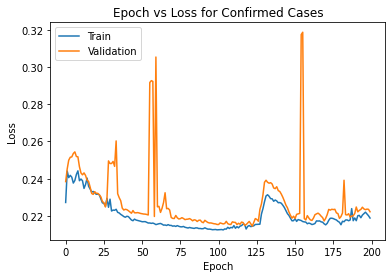

In [108]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Epoch vs Loss for Confirmed Cases')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

In [114]:
last_confirmed = list()
last_confirmed.append(Confirmed[len(Confirmed)-n_steps_in:len(Confirmed)+1])
last_confirmed = np.array(last_confirmed)
print(last_confirmed.shape)


(1, 2, 180)

In [122]:
predictions = model_confirmed.predict(last_confirmed)
predictions.shape
predictions[0]

array([[  285.30887,   441.45444,  1048.8804 ,   479.76172, -3420.487  ,
        -2492.8293 ,  1186.6971 ,  1024.7417 ,   719.96826, 12878.396  ,
        -1116.1755 , -3345.544  ,   672.1965 , -2671.8245 , -6413.038  ,
          281.452  , 15166.856  , -4017.4033 , -3594.558  , -1754.1786 ,
        -2053.4758 ,   582.1419 , -1297.4808 ,  6850.376  ,   289.42242,
          444.163  , -1723.133  , -2602.1313 , -3811.2532 , -2240.157  ,
          156.38266,   239.29543,  1072.0437 ,  -768.1577 , -3589.1733 ,
         3638.2327 ,  2545.7188 ,  1104.1068 , -3599.0657 , -2318.9004 ,
          382.10706,   163.13234,  1071.3862 , -2120.377  ,   436.5494 ,
         3909.8655 ,  1273.6276 ,   872.7753 , -1959.5242 , -2576.6506 ,
         1365.9111 ,  3145.0845 ,   957.15546, -2548.996  , -3049.1985 ,
        -4141.6846 ,   929.2666 , -2963.3564 , -1786.4856 , -2728.8088 ,
         1631.879  ,  6876.5664 , -4094.7517 , -2925.4336 ,   147.53436,
        36982.1    ,   226.03905,  1620.5914 , -127